In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import time
from tensorflow import keras

In [2]:
tf.__version__

'2.4.0'

# full data modeling

In [3]:
# X_train, y_train = np.load('./pre_data/X_train_0801.npy'), np.load('./pre_data/y_train_0801.npy')
# X_valid, y_valid = np.load('./pre_data/X_valid_0801.npy'), np.load('./pre_data/y_valid_0801.npy')
# X_test, y_test = np.load('./pre_data/X_test_0801.npy'), np.load('./pre_data/y_test_0801.npy')

X_train, y_train = np.load('./pre_data/X_train_0714.npy'), np.load('./pre_data/y_train_0714.npy')
X_valid, y_valid = np.load('./pre_data/X_valid_0714.npy'), np.load('./pre_data/y_valid_0714.npy')
X_test, y_test = np.load('./pre_data/X_test_0714.npy'), np.load('./pre_data/y_test_0714.npy')

In [4]:
print('X_train shape : ', X_train.shape, 'X_valid shape : ', X_valid.shape, 'X_test shape : ', X_test.shape)
print('y_train shape : ', y_train.shape, 'y_valid shape : ', y_valid.shape, 'y_test shape : ', y_test.shape)

X_train shape :  (35000, 6000, 10) X_valid shape :  (10000, 6000, 10) X_test shape :  (5000, 6000, 10)
y_train shape :  (35000,) y_valid shape :  (10000,) y_test shape :  (5000,)


# optional

In [5]:
X_train, X_valid, X_test = X_train[:, ::2], X_valid[:, ::2], X_test[:, ::2]

In [6]:
X_train, X_valid, X_test = np.concatenate([X_train[:, :, :1], X_train[:, :, 4:]], axis=-1),\
                           np.concatenate([X_valid[:, :, :1], X_valid[:, :, 4:]], axis=-1),\
                           np.concatenate([X_test[:, :, :1], X_test[:, :, 4:]], axis=-1)

In [7]:
print('X_train shape : ', X_train.shape, 'X_valid shape : ', X_valid.shape, 'X_test shape : ', X_test.shape)
print('y_train shape : ', y_train.shape, 'y_valid shape : ', y_valid.shape, 'y_test shape : ', y_test.shape)

X_train shape :  (35000, 3000, 7) X_valid shape :  (10000, 3000, 7) X_test shape :  (5000, 3000, 7)
y_train shape :  (35000,) y_valid shape :  (10000,) y_test shape :  (5000,)


# class weight

In [8]:
from sklearn.utils.class_weight import compute_class_weight

class_w = compute_class_weight(class_weight = "balanced", 
                     classes=np.unique(y_train), 
                     y = y_train)

cls_weight = {}

for i, w in enumerate(class_w):
    cls_weight[i] = w

In [9]:
cls_weight

{0: 0.8455127430849136,
 1: 1.6826923076923077,
 2: 0.4006868918145392,
 3: 9.333333333333334,
 4: 1.612531674729325}

# modeling

In [10]:
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[1], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)

In [11]:
regularizer = tf.keras.regularizers.L2(0.0003)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[3000, 7]))
model.add(keras.layers.Conv1D(filters=128, kernel_size=12, strides=2, padding="same", 
                              activation="relu", kernel_regularizer=regularizer))
model.add(keras.layers.Conv1D(filters=128, kernel_size=12, strides=2, padding="same", 
                              activation="relu", kernel_regularizer=regularizer))
model.add(keras.layers.Conv1D(filters=128, kernel_size=12, strides=2, padding="same", 
                              activation="relu", kernel_regularizer=regularizer))
model.add(keras.layers.Conv1D(filters=128, kernel_size=12, strides=2, padding="same", 
                              activation="relu", kernel_regularizer=regularizer))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=True, kernel_regularizer=regularizer, dropout=0.7)))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(256, kernel_regularizer=regularizer, dropout=0.7)))
model.add(keras.layers.Dropout(0.7))
model.add(keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizer))
model.add(keras.layers.Dropout(0.7))
model.add(keras.layers.Dense(5))
    
def scheduler(epoch, lr):
    if epoch % 10 == 0:
        return lr * 0.82
    else:
        return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True)

optim = tf.keras.optimizers.Adam(learning_rate = 0.001)

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=optim)

# model.summary()
# model(tf.ones([1, 6000, 6]))
history = model.fit(X_train, y_train, epochs=1000, validation_data=(X_valid, y_valid), callbacks=[lr_callback, early_stop],
                   batch_size=64, class_weight=cls_weight)

# ,class_weight=cls_weight

Epoch 1/1000
547/547 [==============================] - 124s 204ms/step - loss: 2.0278 - val_loss: 1.7370
Epoch 2/1000
547/547 [==============================] - 175s 320ms/step - loss: 1.7232 - val_loss: 1.6702
Epoch 3/1000
547/547 [==============================] - 172s 315ms/step - loss: 1.6545 - val_loss: 1.6320
Epoch 4/1000
547/547 [==============================] - 174s 318ms/step - loss: 1.6427 - val_loss: 1.6230
Epoch 5/1000
547/547 [==============================] - 169s 309ms/step - loss: 1.6163 - val_loss: 1.6210
Epoch 6/1000
547/547 [==============================] - 251s 459ms/step - loss: 1.6129 - val_loss: 1.6131
Epoch 7/1000
547/547 [==============================] - 293s 536ms/step - loss: 1.6081 - val_loss: 1.6117
Epoch 8/1000
547/547 [==============================] - 296s 540ms/step - loss: 1.6137 - val_loss: 1.6064
Epoch 9/1000
547/547 [==============================] - 295s 539ms/step - loss: 1.6153 - val_loss: 1.6151
Epoch 10/1000
547/547 [=======================

547/547 [==============================] - 407s 745ms/step - loss: 1.5907 - val_loss: 1.6094
Epoch 78/1000
547/547 [==============================] - 407s 745ms/step - loss: 1.6068 - val_loss: 1.6094
Epoch 79/1000
547/547 [==============================] - 408s 746ms/step - loss: 1.6152 - val_loss: 1.6096
Epoch 80/1000
547/547 [==============================] - 409s 748ms/step - loss: 1.5869 - val_loss: 1.6097
Epoch 81/1000
547/547 [==============================] - 407s 744ms/step - loss: 1.6109 - val_loss: 1.6096
Epoch 82/1000
547/547 [==============================] - 408s 745ms/step - loss: 1.5983 - val_loss: 1.6093
Epoch 83/1000
547/547 [==============================] - 404s 738ms/step - loss: 1.6012 - val_loss: 1.6096
Epoch 84/1000
547/547 [==============================] - 407s 745ms/step - loss: 1.6031 - val_loss: 1.6099
Epoch 85/1000
547/547 [==============================] - 406s 743ms/step - loss: 1.5950 - val_loss: 1.6097
Epoch 86/1000
547/547 [============================

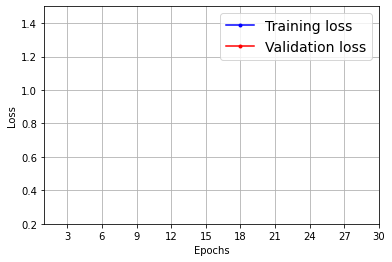

In [12]:
import matplotlib.pyplot as plt
import matplotlib as mpl
 
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 30, 0.2, 1.5])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [13]:
X_test, y_test = X_valid, y_valid

In [14]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 49s 153ms/step - loss: 1.6022


1.6022487878799438

In [15]:
pred = model.predict(X_test)
max_pred = np.argmax(pred, axis = 1)

max_pred.shape, y_test.shape

((10000,), (10000,))

In [16]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import classification_report

target_names = ['1', '2', '3', '4', '5']
cf = confusion_matrix(y_test, max_pred)

for i in range(len(cf)):
    print(target_names[i], ' class confusion matrix : ', cf[i])

1  class confusion matrix :  [2337    0    0    0    0]
2  class confusion matrix :  [1195    0    0    0    0]
3  class confusion matrix :  [5009    0    0    0    0]
4  class confusion matrix :  [226   0   0   0   0]
5  class confusion matrix :  [1233    0    0    0    0]


In [17]:
print(classification_report(y_test, max_pred, target_names = target_names))

              precision    recall  f1-score   support

           1       0.23      1.00      0.38      2337
           2       0.00      0.00      0.00      1195
           3       0.00      0.00      0.00      5009
           4       0.00      0.00      0.00       226
           5       0.00      0.00      0.00      1233

    accuracy                           0.23     10000
   macro avg       0.05      0.20      0.08     10000
weighted avg       0.05      0.23      0.09     10000



/home/ubuntu/anaconda3/envs/tensorflow2.4_p37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tensorflow2.4_p37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/tensorflow2.4_p37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

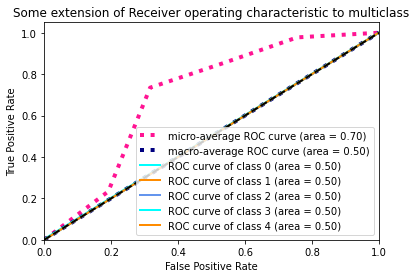

<Figure size 432x288 with 0 Axes>

In [18]:
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from tensorflow.keras.utils import to_categorical

n_classes = 5
fpr = dict()
tpr = dict()
roc_auc = dict()

y_test_c = to_categorical(y_test)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_c[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_c.ravel(), pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes
lw = 2

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

plt.savefig('roc_curve.png')

In [19]:
macro_roc_auc_ovo = roc_auc_score(y_test_c, pred, multi_class="ovo", average="macro")
weighted_roc_auc_ovo = roc_auc_score(
    y_test_c, pred, multi_class="ovo", average="weighted"
)
macro_roc_auc_ovr = roc_auc_score(y_test_c, pred, multi_class="ovr", average="macro")
weighted_roc_auc_ovr = roc_auc_score(
    y_test_c, pred, multi_class="ovr", average="weighted"
)
print(
    "One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo)
)
print(
    "One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr)
)

One-vs-One ROC AUC scores:
0.500578 (macro),
0.500063 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.500578 (macro),
0.500063 (weighted by prevalence)


<AxesSubplot:>

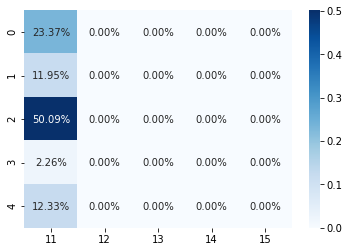

In [20]:
import seaborn as sns

cf_matrix = confusion_matrix(y_test, max_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues', xticklabels=[11, 12, 13, 14, 15])

# model save

In [40]:
model.save('./saved_model/1/')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./saved_model/1/assets


# Test data sampling

In [61]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="1"

regularizer = tf.keras.regularizers.L2(0.0001)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 6], kernel_regularizer=regularizer),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Conv1D(filters=10, kernel_size=4, strides=2, padding="valid", kernel_regularizer=regularizer),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Conv1D(filters=10, kernel_size=4, strides=2, padding="valid", kernel_regularizer=regularizer),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Conv1D(filters=10, kernel_size=2, strides=2, padding="valid", kernel_regularizer=regularizer),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.GRU(20, return_sequences=True, kernel_regularizer=regularizer),
    keras.layers.GRU(20, return_sequences=True, kernel_regularizer=regularizer),
    keras.layers.GRU(20, kernel_regularizer=regularizer),
    keras.layers.Dropout(0.7),
    keras.layers.Dense(5)
])

def scheduler(epoch, lr):
    if epoch is not 0 and epoch % 10 == 0:
        return lr * tf.math.exp(-0.1)
    else:
        return lr 

lr_decay = tf.keras.callbacks.LearningRateScheduler(scheduler)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True)

optim = tf.keras.optimizers.Adam(clipvalue=2)

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=optim)

# model(tf.ones([1, 6000, 6]))
history = model.fit(X_train, y_train, epochs=500, validation_data=(X_valid, y_valid), callbacks=[lr_decay, early_stop], 
                   class_weight=cls_weight)

Epoch 1/500
3750/3750 [==============================] - 442s 118ms/step - loss: 1.5589 - val_loss: 1.4334
Epoch 2/500
3750/3750 [==============================] - 422s 112ms/step - loss: 1.4804 - val_loss: 1.4255
Epoch 3/500
3750/3750 [==============================] - 408s 109ms/step - loss: 1.4642 - val_loss: 1.4688
Epoch 4/500
3750/3750 [==============================] - 407s 108ms/step - loss: 1.4500 - val_loss: 1.5099
Epoch 5/500
3750/3750 [==============================] - 407s 109ms/step - loss: 1.4406 - val_loss: 1.5060
Epoch 6/500
3750/3750 [==============================] - 406s 108ms/step - loss: 1.4318 - val_loss: 1.4443
Epoch 7/500
3750/3750 [==============================] - 414s 110ms/step - loss: 1.4283 - val_loss: 1.5251
Epoch 8/500
3750/3750 [==============================] - 405s 108ms/step - loss: 1.4225 - val_loss: 1.5221
Epoch 9/500
3750/3750 [==============================] - 405s 108ms/step - loss: 1.4204 - val_loss: 1.3896
Epoch 10/500
3750/3750 [=============

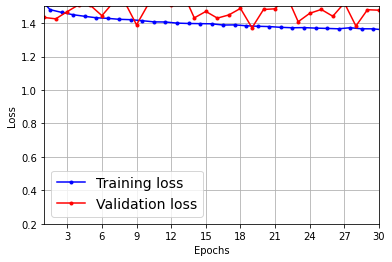

In [62]:
import matplotlib.pyplot as plt
import matplotlib as mpl

def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 30, 0.2, 1.5])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [63]:
model.evaluate(X_valid, y_valid)

625/625 [==============================] - 16s 26ms/step - loss: 1.3719 0s - loss: 1.37


1.371914267539978

In [64]:
pred = model.predict(X_test)
max_pred = np.argmax(pred, axis = 1)

max_pred.shape, y_test.shape

((21959,), (21959,))

In [65]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import classification_report

target_names = ['Wake', 'N1', 'N2', 'N3', 'R']
cf = confusion_matrix(y_test, max_pred)

for i in range(len(cf)):
    print(target_names[i], ' class confusion matrix : ', cf[i])

Wake  class confusion matrix :  [ 122 3100  140  260 3367]
N1  class confusion matrix :  [ 120 5794  162  176 3923]
N2  class confusion matrix :  [  46 1504   63  161 1517]
N3  class confusion matrix :  [ 10  19   0 237 326]
R  class confusion matrix :  [ 11 278  13  20 590]


In [66]:
print(classification_report(y_test, max_pred, target_names = target_names))

              precision    recall  f1-score   support

        Wake       0.39      0.02      0.03      6989
          N1       0.54      0.57      0.56     10175
          N2       0.17      0.02      0.03      3291
          N3       0.28      0.40      0.33       592
           R       0.06      0.65      0.11       912

    accuracy                           0.31     21959
   macro avg       0.29      0.33      0.21     21959
weighted avg       0.41      0.31      0.29     21959



In [67]:
model.save('./saved_model/1/')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./saved_model/1/assets


In [ ]:
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

# regularizer = tf.keras.regularizers.L2(0.0001)

# model = keras.models.Sequential([
#     keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal", dilation_rate=1,
#                         input_shape=[3002, 6], kernel_regularizer=regularizer),
#     keras.layers.BatchNormalization(),
#     keras.layers.Activation('relu'),
#     keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal", dilation_rate=2, kernel_regularizer=regularizer),
#     keras.layers.BatchNormalization(),
#     keras.layers.Activation('relu'),
#     keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal", dilation_rate=4, kernel_regularizer=regularizer),
#     keras.layers.BatchNormalization(),
#     keras.layers.Activation('relu'),
#     keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal", dilation_rate=8, kernel_regularizer=regularizer),
#     keras.layers.BatchNormalization(),
#     keras.layers.Activation('relu'),
#     keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal", dilation_rate=1, kernel_regularizer=regularizer),
#     keras.layers.BatchNormalization(),
#     keras.layers.Activation('relu'),
#     keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal", dilation_rate=2, kernel_regularizer=regularizer),
#     keras.layers.BatchNormalization(),
#     keras.layers.Activation('relu'),
#     keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal", dilation_rate=4, kernel_regularizer=regularizer),
#     keras.layers.BatchNormalization(),
#     keras.layers.Activation('relu'),
#     keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal", dilation_rate=8, kernel_regularizer=regularizer),
#     keras.layers.BatchNormalization(),
#     keras.layers.Activation('relu'),
#     keras.layers.Conv1D(filters=40, kernel_size=2, strides=2, padding="same", kernel_regularizer=regularizer),
#     keras.layers.BatchNormalization(),
#     keras.layers.Activation('relu'),
#     keras.layers.Conv1D(filters=40, kernel_size=2, strides=2, padding="same", kernel_regularizer=regularizer),
#     keras.layers.BatchNormalization(),
#     keras.layers.Activation('relu'),
#     keras.layers.GRU(20, return_sequences=True, kernel_regularizer=regularizer),
#     keras.layers.GRU(20, return_sequences=True, kernel_regularizer=regularizer),
#     keras.layers.GRU(20, kernel_regularizer=regularizer),
#     keras.layers.Dropout(0.7),
#     keras.layers.Dense(5)
# ])

# def scheduler(epoch, lr):
#     if epoch is not 0 and epoch % 10 == 0:
#         return lr * tf.math.exp(-0.1)
#     else:
#         return lr 

# lr_decay = tf.keras.callbacks.LearningRateScheduler(scheduler)

# early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=30, verbose=0,
#     mode='auto', baseline=None, restore_best_weights=True)

# optim = tf.keras.optimizers.Adam(learning_rate=0.001, clipvalue=0.5)

# model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=optim)

# # model.summary()

# # model(tf.ones([1, 6000, 6]))
# history = model.fit(X_train, y_train, epochs=200, batch_size = 16, validation_data=(X_valid, y_valid), 
#                     callbacks=[lr_decay, early_stop])

In [ ]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="1"

regularizer = tf.keras.regularizers.L2(0.0001)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="same",
                        input_shape=[3002, 6], kernel_regularizer=regularizer),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(),
#     keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="same", kernel_regularizer=regularizer),
#     keras.layers.BatchNormalization(),
#     keras.layers.LeakyReLU(),
#     keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="same", kernel_regularizer=regularizer),
#     keras.layers.BatchNormalization(),
#     keras.layers.LeakyReLU(),
#     keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="same", kernel_regularizer=regularizer),
#     keras.layers.BatchNormalization(),
#     keras.layers.LeakyReLU(),
#     keras.layers.GRU(20, return_sequences=True, kernel_regularizer=regularizer),
    keras.layers.GRU(20, return_sequences=True, kernel_regularizer=regularizer),
    keras.layers.GRU(20, kernel_regularizer=regularizer),
    keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizer),
    keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizer),
    keras.layers.Dense(5)
])

def scheduler(epoch, lr):
    if epoch % 5 == 0:
        return lr * tf.math.exp(-0.1)
    else:
        return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=30, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True)

optim = tf.keras.optimizers.Adam(learning_rate = 0.001, clipvalue=0.5)

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=optim)

# model.summary()
# model(tf.ones([1, 6000, 6]))
history = model.fit(X_train, y_train, epochs=300, validation_data=(X_valid, y_valid), callbacks=[lr_decay, early_stop],
                   batch_size=16)

# ,class_weight=cls_weight